# Part 3: Zonal Statistics and Comparative Analysis

In this third section of the assignment project, the code uses libraries like `rasterstats` to perform zonal statistics. The latter is a set of analytical techniques used in Geographic Information Systems (GIS) to calculate statistics on values from a **raster dataset** within **zones** defined by another dataset. These zones can be defined by features such as polygons in a vector layer or by areas of consistent value in a raster layer. We will use the **join** shapefile produced in Part 1 of the code to define such zones, so as to obtain mean NDVI and habitat connectivity values for each agricultural plot. This process facilitates a comprehensive analysis of vegetation health and landscape connectivity, which are critical for sustainable agricultural management. By integrating NDVI and connectivity data, we can evaluate the ecological value of agricultural lands, informing strategies to enhance biodiversity conservation within agricultural practices.

First, let's load all the files necessary for this part of the project.

In [1]:
import rasterio as rio

#Open the .tif which contains the NDVI calculation from Part 2
ndvi_path="Data_files/Output_files/clipped_ndvi.tif"
ndvi=rio.open(ndvi_path)

import geopandas as gpd

#load the join shapefile from Part 1
join_path = 'Data_files/Output_files/joined_with_area.shp'
join = gpd.read_file(join_path)

## Calculating NDVI Statistics

Before we can perform zonal statistics, we want to make sure that the coordinate reference system (CRS) of the **join** shapefile is the same as the CRS of the **NDVI** raster data. This is crucial as spatial operations require both datasets to be in the same CRS to ensure accurate analysis. 

After this, we can proceed to define the parameters to calculate zonal statistics and append results to a shapefile. The code below does this using the `zonal_stats` function and saves the combined DataFrame as a GeoJSON file.

In [2]:
from rasterstats import zonal_stats
import pandas as pd

temp = join.to_crs(crs=ndvi.crs.data)

#Define the parameters to calculate the zonal statistics
array = ndvi.read(1)
affine = ndvi.transform
zs_ndvi = zonal_stats(temp, array, affine=affine, stats=['mean', 'min', 'max', 'std'])

#Append the results to a pandas' dataframe
ndviframe = pd.DataFrame(zs_ndvi)

# Specify suffixes for overlapping columns
suffixes = "_ndvi"
join = join.join(ndviframe.add_suffix(suffixes))
join.to_file("Data_files/Output_files/ZonalStatsNDVI_Polygons.geojson", driver='GeoJSON')

join.head()

C:\Users\M533\anaconda3\envs\Assignment\Lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


,CODICE,DESC_,Plot_ha,index_righ,R_LEGISL,NAME,CODEAP,decree,Publ,Area_ha,management,CLASS,int_ha,geometry,min_ndvi,max_ndvi,mean_ndvi,std_ndvi
0,221,vineyards,0.395399,NaN,None,None,None,None,None,NaN,None,None,0.000000,"POLYGON Z ((647468.894 4520416.843 0.000, 6474...",0.229435,0.239988,0.231545,0.004221
1,221,vineyards,0.507260,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,Ente Parco Nazionale dell' Alta Murgia,Parchi nazionali e riserve naturali statali,0.507260,"POLYGON Z ((640443.620 4528059.830 0.000, 6404...",0.157108,0.211014,0.172510,0.024352
2,221,vineyards,0.451273,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,Ente Parco Nazionale dell' Alta Murgia,Parchi nazionali e riserve naturali statali,0.446702,"POLYGON Z ((644611.482 4519606.510 0.000, 6445...",0.470588,0.511093,0.477339,0.015095
3,222,orchards and minor fruits,4.685679,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,Ente Parco Nazionale dell' Alta Murgia,Parchi nazionali e riserve naturali statali,4.685679,"POLYGON Z ((646206.803 4523193.705 0.000, 6462...",0.289058,0.340206,0.312473,0.025003
4,222,orchards and minor fruits,0.335897,NaN,None,None,None,None,None,NaN,None,None,0.000000,MULTIPOLYGON Z (((647587.885 4524979.883 0.000...,0.269962,0.279495,0.274728,0.004767


### Visualizing NDVI mean values of Agricultural Plots
Now we can visualise the agricultural plots by mean_ndvi values using `matplotlib.pyplot`.

Text(0.5, 1.0, 'Mean NDVI by Agricultural Plot')

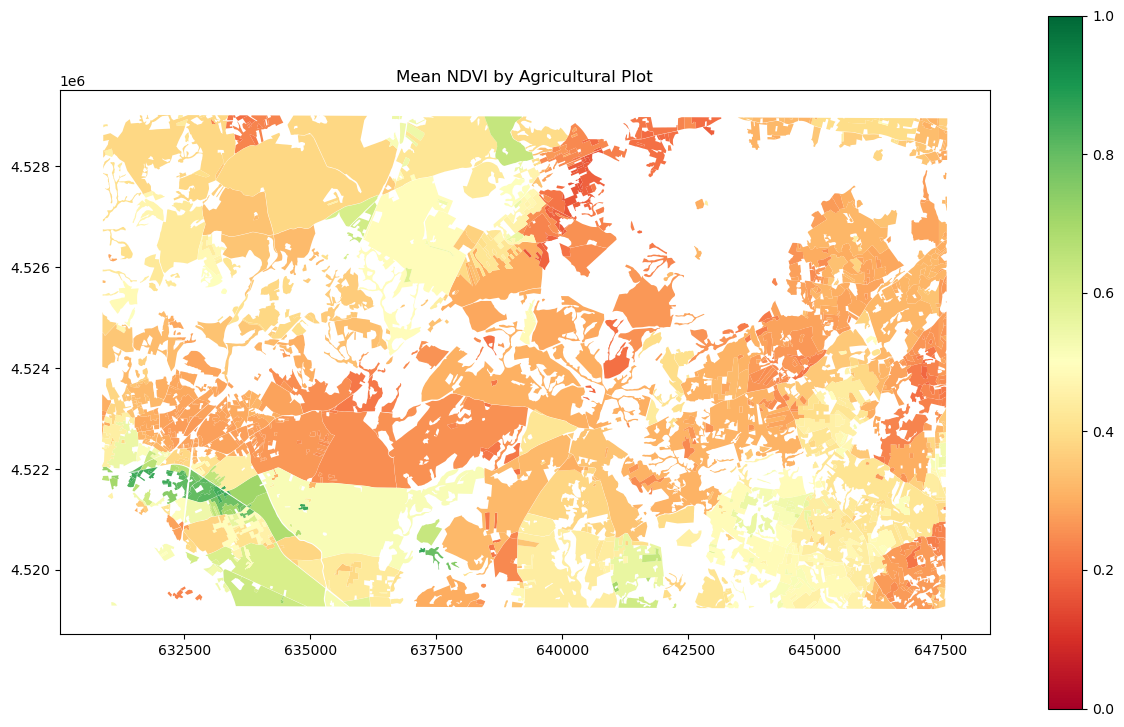

In [38]:
import matplotlib.pyplot as plt
meanmap = join.plot(column='mean_ndvi', cmap =    
                                'RdYlGn', vmin=0, vmax=1, figsize=(15,9), legend =  
                                  True);
plt.title("Mean NDVI by Agricultural Plot")

## Habitat Connectivity

**Habitat connectivity** refers to the degree to which different patches of habitat are connected, affecting the movement, distribution, genetic diversity, and overall health of animal and plant populations. It is a critical aspect of conservation biology, as it allows for the movement of species in search of food, mates, and new habitats, which is essential for maintaining biodiversity, ecological functions, and resilience against environmental changes. 

The presented project uses habitat connectivity data developed as part of my [BSc dissertation research](https://www.linkedin.com/posts/mariavittoria-santarelli_sustainableagriculture-agroecological-community-activity-6954342396763504641-3Ndx?utm_source=share&utm_medium=member_desktop). The latter produced habitat connectivity maps for a defined rural bird species (*Lanius Senator*, also known as Woodchat Shrike). These will be used to extract habitat connectivity values for agricultural plots and explore any potential relationship with NDVI. This is done on the grounds that NDVI is a measure of vegetation greenness and health, and it can be an important predictor in habitat selection for certain species during migration. For instance, areas with higher NDVI values may indicate more suitable habitats or corridors for wildlife movement. 

### Clipping Habitat Connectivity to AOI

The code below uses `rastario` and `rasterio.mask` to open and clip the habitat connectivity raster to the AOI.

In [4]:
from rasterio.mask import mask

# Open the raster file which contains the habitat connectivity calculation with rasterio
hab_con_path="Data_files/habconmap"

# Load the habitat connectivity raster
with rio.open(hab_con_path) as habcon_src:
    habcon_data = habcon_src.read(1)
    habcon_transform = habcon_src.transform

    # Load the search area polygon
    AOI_path = 'Data_files/Area_of_interest.shp'
    AOI = gpd.read_file(AOI_path)

    # Clip the NDVI data to the search area
    clipped_habcon_data, clipped_habcon_transform = mask(habcon_src, shapes=AOI.geometry, crop=True)

    # Define the output path for the clipped NDVI raster file
    clipped_habcon_path = 'Data_files/Output_files/clipped_habcon.tif'
    with rio.open(clipped_habcon_path, 'w', **habcon_src.meta) as clipped_habcon_dst:
        clipped_habcon_dst.write(clipped_habcon_data)

    print(f"Clipped NDVI saved to {clipped_habcon_path}")

Clipped NDVI saved to Data_files/Output_files/clipped_habcon.tif


### Visualizing Habitat Connectivity Raster

Now we can plot the clipped Habitat Connectivity raster to visualise it using `matplotlib.pyplot`. Habitat Connectivity maps normally range between 0 and 1, with 0 being areas that are impermeable to animal movement, and 1 being patch habitat area (i.e. of maximum connectivity). For better visualization we can adjust the `vmax` argument so that our data is easier to interpret. In the plot below, areas of low connectivity are in blue, while areas with higher connectvity are displayed in colors from red to purple. 

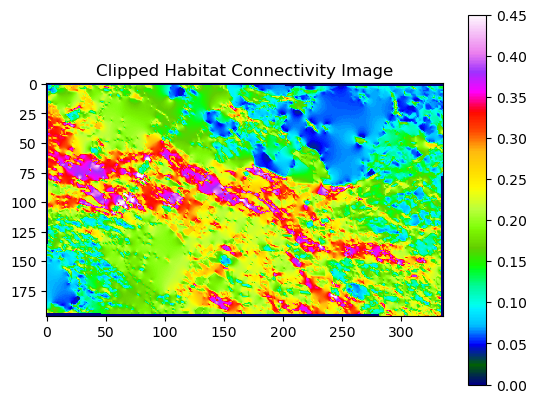

In [9]:
# Plot the clipped habitat connectivity
plt.imshow(clipped_habcon_data[0], cmap='gist_ncar', vmin=0, vmax=0.45)
plt.colorbar()
plt.title('Clipped Habitat Connectivity Image')
plt.show()

### Calculating Habitat Connectivity Statistics 

Now we can perform again zonal statistics using `zonal_stats` as above. This time we will use the GeoJSON file with NDVI values as the file to use in the join.

In [11]:
# Open the raster file which contains the habitat connectivity calculation with rasterio
hab_con_path = 'Data_files/Output_files/clipped_habcon.tif'
hab_con = rio.open(hab_con_path)

# Load the join shapefile
lastjoin_path = "Data_files/Output_files/ZonalStatsNDVI_Polygons.geojson"
lastjoin = gpd.read_file(lastjoin_path)

# Define the parameters to calculate the zonal stats
array = hab_con.read(1)
affine = hab_con.transform
zs_hab_con = zonal_stats(lastjoin, array, affine=affine, stats=["mean", "min", "max", "std"])

# Append the results to a pandas' dataframe
hab_con_frame = pd.DataFrame(zs_hab_con)

# Specify suffixes for overlapping columns
suffixes = "_hab"
lastjoin = lastjoin.join(hab_con_frame.add_suffix(suffixes))

# Save the file
lastjoin.to_file("Data_files/Output_files/ZonalStatsNDVI_habitatconnectivity.geojson", driver='GeoJSON')

lastjoin_path = "Data_files/Output_files/ZonalStatsNDVI_habitatconnectivity.geojson"
lastjoin = gpd.read_file(lastjoin_path)
lastjoin.head()

,CODICE,DESC_,Plot_ha,index_righ,R_LEGISL,NAME,CODEAP,decree,Publ,Area_ha,...,int_ha,min_ndvi,max_ndvi,mean_ndvi,std_ndvi,min_hab,max_hab,mean_hab,std_hab,geometry
0,221,vineyards,0.395399,NaN,None,None,None,None,None,NaN,...,0.000000,0.229435,0.239988,0.231545,0.004221,0.245051,0.245051,0.245051,0.000000e+00,"POLYGON Z ((647468.894 4520416.843 0.000, 6474..."
1,221,vineyards,0.507260,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,...,0.507260,0.157108,0.211014,0.172510,0.024352,0.257080,0.257080,0.257080,0.000000e+00,"POLYGON Z ((640443.620 4528059.830 0.000, 6404..."
2,221,vineyards,0.451273,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,...,0.446702,0.470588,0.511093,0.477339,0.015095,0.222153,0.222153,0.222153,0.000000e+00,"POLYGON Z ((644611.482 4519606.510 0.000, 6445..."
3,222,orchards and minor fruits,4.685679,0.0,L. n. 426 del 09.12.1998,Parco nazionale dell'Alta Murgia,EUAP0852,DPR 10.03.2004,GU n. 152 del 1.07.2004,68032.666725,...,4.685679,0.289058,0.340206,0.312473,0.025003,0.334193,0.334193,0.334193,1.324548e-08,"POLYGON Z ((646206.803 4523193.705 0.000, 6462..."
4,222,orchards and minor fruits,0.335897,NaN,None,None,None,None,None,NaN,...,0.000000,0.269962,0.279495,0.274728,0.004767,0.253226,0.253226,0.253226,0.000000e+00,MULTIPOLYGON Z (((647587.885 4524979.883 0.000...


### Visualizing Habitat Connectivity mean values of Agricultural Plots
Now we can visualise the agricultural plots by mean_hab values using `matplotlib.pyplot`.

Text(0.5, 1.0, 'Mean Habitat Connectivity by Agricultural Plot')

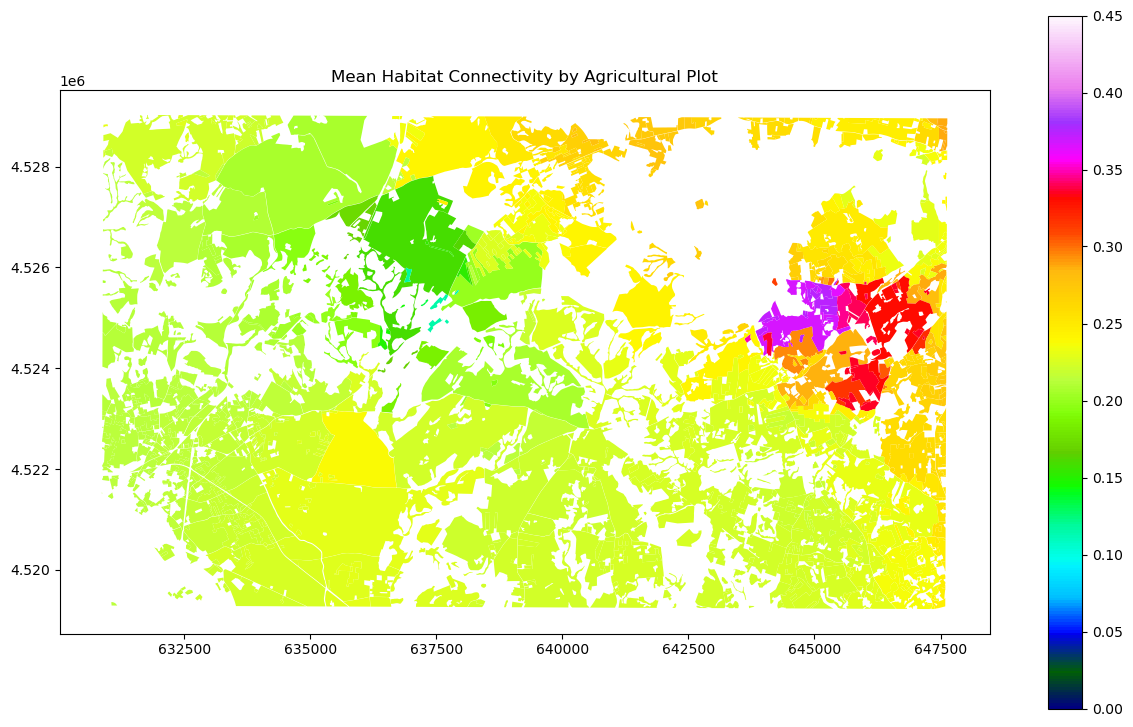

In [15]:
meanmap = lastjoin.plot(column='mean_hab', cmap =    
                                'gist_ncar', vmin=0, vmax=0.45, figsize=(15,9), legend =  
                                  True);
plt.title("Mean Habitat Connectivity by Agricultural Plot")

## Comparative Analysis of NDVI and Habitat Connectivity

Our final GeoDataFrame **lastjoin** now contains enough data to perform some comparative and statistical analysis.

### Summary Statistics

First of all we can look at different summary stats per management type using the `groupby` function.
#### Mean NDVI per Management Type

In [16]:
lastjoin.groupby('DESC_')['mean_ndvi'].mean()

DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces    0.458056
complex cultivation and parcel systems                                             0.404545
olive groves                                                                       0.374895
orchards and minor fruits                                                          0.339965
other permanent crops                                                              0.475190
simple arable land in non-irrigated areas                                          0.380470
surfaces with dense herbaceous cover                                               0.313923
temporary crops associated with permanent crops                                    0.394136
vineyards                                                                          0.431577
Name: mean_ndvi, dtype: float64

#### Mean Habitat Connectivity per Management Type

In [17]:
lastjoin.groupby('DESC_')['mean_hab'].mean()

DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces    0.218499
complex cultivation and parcel systems                                             0.221459
olive groves                                                                       0.233020
orchards and minor fruits                                                          0.244957
other permanent crops                                                              0.260127
simple arable land in non-irrigated areas                                          0.230560
surfaces with dense herbaceous cover                                               0.215975
temporary crops associated with permanent crops                                    0.240741
vineyards                                                                          0.232561
Name: mean_hab, dtype: float64

### Statistical Correlations between NDVI and Habitat Connectivity
We can also calculate the statistical correlation between variables. 

#### Pearson's and Spearman's Correlations
The code below uses the `.corr` function in the `pandas` library to calculate and print (rounded to 2 decimal places) the Pearson's and Spearman's correlation coefficients between NDVI and Habitat Connectivity values.

In [18]:
correlation = lastjoin['mean_ndvi'].corr(lastjoin['mean_hab'])
print(f"Pearson's correlation coefficient: {correlation:.2f}")

spearman_corr = lastjoin['mean_ndvi'].corr(lastjoin['mean_hab'], method='spearman')
print(f"Spearman's rank correlation coefficient: {spearman_corr:.2f}")

Pearson's correlation coefficient: -0.25
Spearman's rank correlation coefficient: -0.30


#### Pearson's and Spearman's Correlation per Management Type

In our analysis, we can extend our investigation to include the impact of different **management types** on the relationship between NDVI (Normalized Difference Vegetation Index) and Habitat Connectivity. Both of these factors can be influenced by how the land is managed. For instance, certain management practices might enhance both vegetation health and habitat connectivity, leading to a positive correlation between NDVI and Habitat Connectivity. On the other hand, some management types might improve one at the expense of the other, resulting in a negative correlation.

By calculating the statistical correlation separately for each management type using the `groupby` function, the code below explores whether the management practices influence the correlation between these two variables. The code below only calculates the correlation for groups with more than two rows of data, as less than this wouldn't produce significant results, and assigns the value None for groups with less than two rows. The `include_groups=False` argument was used to silence the deprecation warnings.

In [25]:
Pearson_by_group = lastjoin.groupby('DESC_').apply(lambda group: group['mean_ndvi'].corr(group['mean_hab']) if len(group) > 2 else None, include_groups=False)

Spearman_by_group = lastjoin.groupby('DESC_').apply(lambda group: group['mean_ndvi'].corr(group['mean_hab'], method='spearman') if len(group) > 2 else None, include_groups=False)

print("Pearson's Correlation by Management Type:")
print(Pearson_by_group)

print("Spearman's Correlation by Management Type:")
print(Spearman_by_group)

Pearson's Correlation by Management Type:
DESC_
areas mainly occupied by agricultural crops with the presence of natural spaces         NaN
complex cultivation and parcel systems                                             0.186708
olive groves                                                                      -0.249913
orchards and minor fruits                                                         -0.305782
other permanent crops                                                                   NaN
simple arable land in non-irrigated areas                                         -0.226979
surfaces with dense herbaceous cover                                              -0.332523
temporary crops associated with permanent crops                                    0.509425
vineyards                                                                         -0.372463
dtype: float64
Spearman's Correlation by Management Type:
DESC_
areas mainly occupied by agricultural crops with the presenc

### Statistical Correlations between Intersection Area with PAs and Habitat Connectivity

Another thing that we can look at is the correlation between intersection area with **Protected Areas** (PAs) and habitat connectivity. This is a valuable avenue of investigation as it allows us to understand how protected regions interact with the overall connectivity of habitats. 

Protected Areas often serve as crucial nodes in habitat networks, providing safe havens for biodiversity and facilitating species movement across landscapes. Therefore, the size of the intersection area with PAs can potentially influence habitat connectivity. By calculating the correlation between the intersection area with PAs and habitat connectivity, we can quantify this relationship. A positive correlation might suggest that larger intersection areas with PAs are associated with higher habitat connectivity, indicating the role of PAs in enhancing landscape connectivity. Conversely, a negative correlation could point towards other factors at play, such as the location and distribution of PAs, that might be impacting habitat connectivity.

In [26]:
correlation = lastjoin['int_ha'].corr(lastjoin['mean_hab'])
print(f"Pearson's correlation coefficient: {correlation:.2f}")

spearman_corr = lastjoin['int_ha'].corr(lastjoin['mean_hab'], method='spearman')
print(f"Spearman's rank correlation coefficient: {spearman_corr:.2f}")

Pearson's correlation coefficient: 0.05
Spearman's rank correlation coefficient: 0.38


This is the end of Part 3 of the code. The next and last section creates different functions to display the obtained results.